# Task 1 : Configuration 

In [ ]:
!pip install timm

In [ ]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import timm 
import os 
from tqdm.notebook import tqdm 

from helper import view_classify, show_image, show_grid, accuracy

In [ ]:
# chest_xray_data download link
# https://drive.google.com/drive/folders/1tgdetY_W0U_5_f9cYezBCPmbtIxgwybF?usp=sharing 

In [ ]:
class CFG:
    
    epochs = 20                                        # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset 
    
    model_name = 'tf_efficientnet_b4_ns'               # Model name (We are going to import model from timm)
    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = "/content/drive/MyDrive/chest_xray_data"                       # Data Directory 
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VAL ='val'                                         # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On which device we are on : {}".format(device))

On which device we are on : cuda


# Task 2 : Image Transformation and Load Dataset 

In [ ]:
from torchvision import transforms as T, datasets

In [ ]:
train_transform = T.Compose([
            
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.RandomRotation(degrees = (-20,+20)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

valid_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [ ]:
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path,transform = train_transform)
validset = datasets.ImageFolder(valid_path,transform = valid_transform)
testset = datasets.ImageFolder(test_path,transform = test_transform)

In [ ]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5236
Validset Size : 16
Testset Size : 624


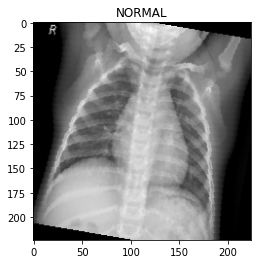

In [ ]:
image, label = trainset[2]

class_names = ['NORMAL','PNEUMONIA']

show_image(image,class_names[label])

# Load Dataset into Batches 

In [ ]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = CFG.batch_size , shuffle = True)
validloader = DataLoader(validset, batch_size = CFG.batch_size , shuffle = True)
testloader = DataLoader(testset, batch_size = CFG.batch_size , shuffle = True)

In [ ]:
print("No. of batches in trainloader : {}".format(len(trainloader)))
print("No. of Total examples : {}".format(len(trainloader.dataset)))

No. of batches in trainloader : 328
No. of Total examples : 5236


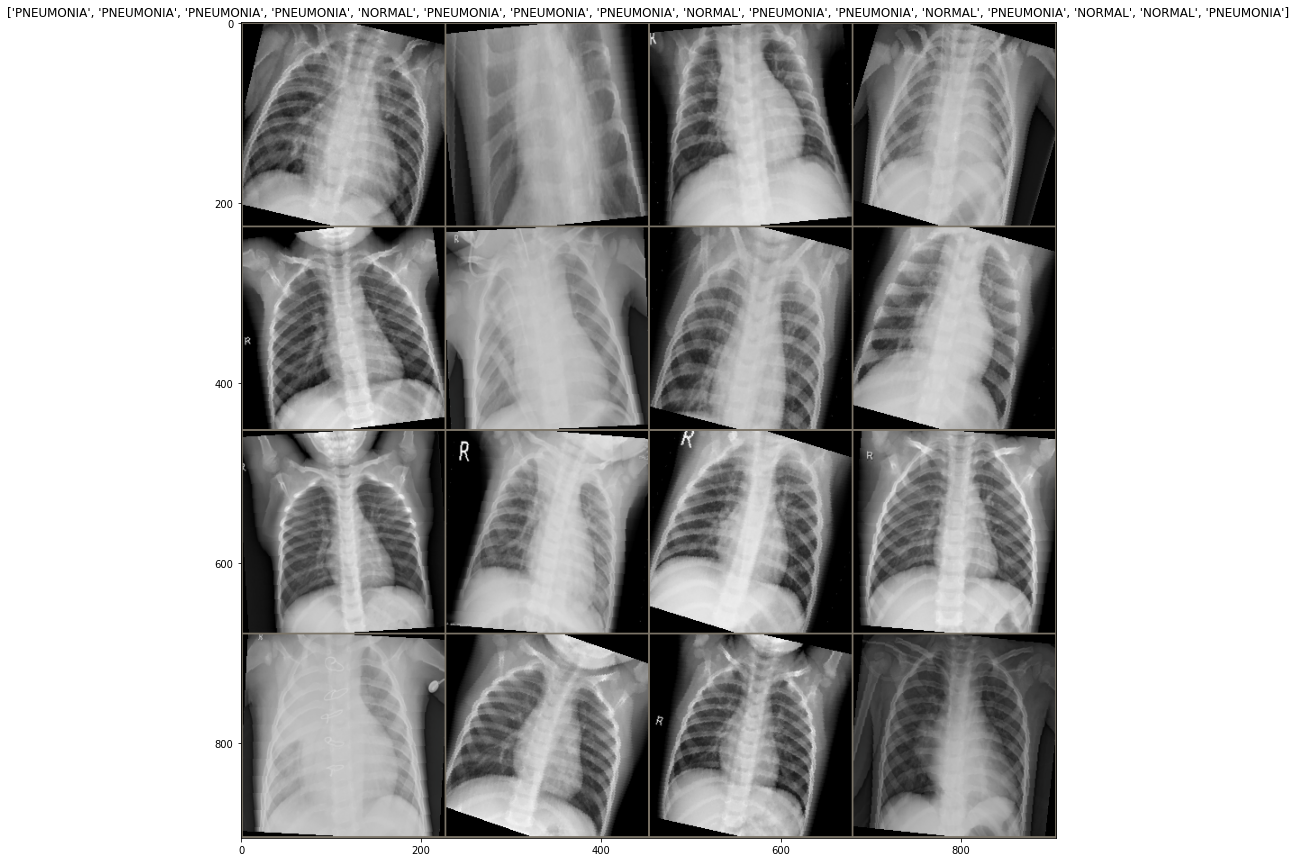

In [ ]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out, title=[class_names[x] for x in labels])

# Fine Tuning EfficientNet Model 

In [ ]:
from torch import nn 
import torch.nn.functional as F

model = timm.create_model(CFG.model_name,pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(

        nn.Linear(in_features = 1792, out_features = 625),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(in_features = 625, out_features = 256),
        nn.ReLU(),
        nn.Linear(in_features = 256, out_features = 2)

)

model.to(device)

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv

# Build a Simple Trainer

In [ ]:
class PneumoniaTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader)
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabPneumoniaModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

# Training Model 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = PneumoniaTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validloader,epochs = CFG.epochs)


Valid_loss decreased inf --> 0.5237141251564026
Epoch : 1 Train Loss : 0.276768 Train Acc : 0.883003
Epoch : 1 Valid Loss : 0.523714 Valid Acc : 0.750000



Valid_loss decreased 0.5237141251564026 --> 0.43365922570228577
Epoch : 2 Train Loss : 0.201389 Train Acc : 0.920351
Epoch : 2 Valid Loss : 0.433659 Valid Acc : 0.875000



Epoch : 3 Train Loss : 0.186707 Train Acc : 0.924352
Epoch : 3 Valid Loss : 0.637275 Valid Acc : 0.750000



Epoch : 4 Train Loss : 0.176371 Train Acc : 0.929688
Epoch : 4 Valid Loss : 0.631884 Valid Acc : 0.625000



Epoch : 5 Train Loss : 0.178739 Train Acc : 0.928544
Epoch : 5 Valid Loss : 0.864055 Valid Acc : 0.500000



Epoch : 6 Train Loss : 0.165638 Train Acc : 0.939596
Epoch : 6 Valid Loss : 0.478423 Valid Acc : 0.812500



Epoch : 7 Train Loss : 0.175369 Train Acc : 0.933308
Epoch : 7 Valid Loss : 0.503556 Valid Acc : 0.687500



Epoch : 8 Train Loss : 0.168597 Train Acc : 0.930450
Epoch : 8 Valid Loss : 0.757202 Valid Acc : 0.562500



Epoch : 9 Train Loss : 0.167181 Train Acc : 0.931402
Epoch : 9 Valid Loss : 0.550101 Valid Acc : 0.562500



Epoch : 10 Train Loss : 0.154454 Train Acc : 0.938072
Epoch : 10 Valid Loss : 0.464715 Valid Acc : 0.812500



Valid_loss decreased 0.43365922570228577 --> 0.38164734840393066
Epoch : 11 Train Loss : 0.151104 Train Acc : 0.942264
Epoch : 11 Valid Loss : 0.381647 Valid Acc : 0.812500



Epoch : 12 Train Loss : 0.146552 Train Acc : 0.941501
Epoch : 12 Valid Loss : 0.407854 Valid Acc : 0.875000



Epoch : 13 Train Loss : 0.157826 Train Acc : 0.937119
Epoch : 13 Valid Loss : 0.592591 Valid Acc : 0.500000



Epoch : 14 Train Loss : 0.153444 Train Acc : 0.939977
Epoch : 14 Valid Loss : 0.754640 Valid Acc : 0.562500



Epoch : 15 Train Loss : 0.139406 Train Acc : 0.943979
Epoch : 15 Valid Loss : 0.699588 Valid Acc : 0.500000



Epoch : 16 Train Loss : 0.150705 Train Acc : 0.942454
Epoch : 16 Valid Loss : 0.738870 Valid Acc : 0.687500



Epoch : 17 Train Loss : 0.143900 Train Acc : 0.943788
Epoch : 17 Valid Loss : 0.757309 Valid Acc : 0.562500



Epoch : 18 Train Loss : 0.136630 Train Acc : 0.947409
Epoch : 18 Valid Loss : 0.864474 Valid Acc : 0.500000



Epoch : 19 Train Loss : 0.150083 Train Acc : 0.941501
Epoch : 19 Valid Loss : 1.007684 Valid Acc : 0.500000



Epoch : 20 Train Loss : 0.142935 Train Acc : 0.945312
Epoch : 20 Valid Loss : 0.463322 Valid Acc : 0.750000


# Plot Results 

In [ ]:
model.load_state_dict(torch.load('/content/ColabPneumoniaModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))


Test Loss : 0.2958929422192084
Test Acc : 0.879807710647583


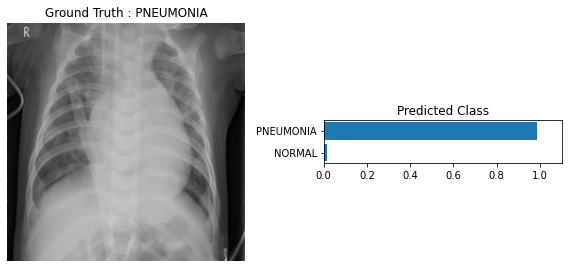

In [ ]:
import torch.nn.functional as F

image,label = testset[324]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)